# Lambda Client Examples using the new database schema

These are some initial examples to illustrate how to work with the new database schema using the AWS Lambda client. We will continue updating the existing gallery to follow these patterns.

In [1]:
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import pandas as pd
from shapely.geometry import box

from snowexsql.lambda_client import SnowExLambdaClient

In [2]:
# Initialize client
client = SnowExLambdaClient()

# Get all measurement classes dynamically
classes = client.get_measurement_classes()
PointMeasurements = classes['PointMeasurements']
LayerMeasurements = classes['LayerMeasurements']
RasterMeasurements = classes['RasterMeasurements']


print("🔍 Testing Lambda connection...")
connection_test = client.test_connection()
print(f"✅ Connected: {connection_test.get('connected', False)}")
if connection_test.get('connected'):
    print(f"📊 Database: {connection_test.get('version', 'Unknown version')}")
else:
    print("❌ Connection failed")

🔍 Testing Lambda connection...
✅ Connected: True
📊 Database: PostgreSQL 16.10 on x86_64-conda-linux-gnu, compiled by x86_64-conda-linux-gnu-cc (conda-forge gcc 14.3.0-4) 14.3.0, 64-bit


## Query and access data using spatial bounding box

Many people will want to explore what types of SnowEx data might be available in a region of interest. Here is an example showing how to do this for layer dataset.

In [3]:
# Create polygon from bounding box (minx, miny, maxx, maxy)
bbox_polygon = box(
    minx=-116.14,  # min longitude (west)
    miny=43.73,    # min latitude (south)
    maxx=-116.04,  # max longitude (east)
    maxy=43.8     # max latitude (north)
)

# Convert to WKT for query
bbox_wkt = bbox_polygon.wkt

# Create a GeoDataFrame from the bounding box polygon
bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox_polygon], crs='EPSG:4326')

# Reproject to Web Mercator for basemap
bbox_gdf_web = bbox_gdf.to_crs(epsg=3857)


Let's query the database for all the types of data associated with Layer Data:

In [5]:
# Get all available types first
all_types = LayerMeasurements.all_types
print(f"Available types: {all_types}")

Available types: ['density', 'grain_size', 'grain_type', 'hand_hardness', 'manual_wetness', 'comments', 'permittivity', 'liquid_water_content', 'snow_temperature', 'force', 'sample_signal', 'reflectance', 'specific_surface_area', 'equivalent_diameter']


Now we can query the database by area and type. We'll work with snow temperature data.

In [12]:
print("Getting layer data within bounding box...")
df = LayerMeasurements.from_area(
    shp=bbox_polygon,
    date_greater_equal=date(2020, 1, 1),
    date_less_equal=date(2022, 12, 30),
    crs=4326,
    type='snow_temperature',
    limit=600,
    verbose=True
)

print(f"Retrieved {len(df)} records.")

Getting layer data within bounding box...
Retrieved 586 records.


Take a quick look at the data. Note with `verbose=True` we get a lot of associated metadata returned.  

In [14]:
df.head()

,depth,bottom_depth,value,site_name,site_description,slope_angle,aspect,air_temp,total_depth,weather_description,...,date,geom,type,units,type_derived,instrument_name,instrument_model,instrument_specifications,geom_wkt,geometry
0,80.0,None,0.0,IDBRLO_20200304_1210,None,19.0,135.0,5.8,90.0,"scattered clouds, light wind, sunny",...,2020-03-04T19:10:00+00:00,0101000020e6100000990d32c9c8075dc08a1f63ee5ade...,snow_temperature,deg c,False,Digital Thermometer,None,None,POINT(-116.12163 43.73715),POINT (-116.12163 43.73715)
1,70.0,None,0.0,IDBRLO_20200304_1210,None,19.0,135.0,5.8,90.0,"scattered clouds, light wind, sunny",...,2020-03-04T19:10:00+00:00,0101000020e6100000990d32c9c8075dc08a1f63ee5ade...,snow_temperature,deg c,False,Digital Thermometer,None,None,POINT(-116.12163 43.73715),POINT (-116.12163 43.73715)
2,60.0,None,0.0,IDBRLO_20200304_1210,None,19.0,135.0,5.8,90.0,"scattered clouds, light wind, sunny",...,2020-03-04T19:10:00+00:00,0101000020e6100000990d32c9c8075dc08a1f63ee5ade...,snow_temperature,deg c,False,Digital Thermometer,None,None,POINT(-116.12163 43.73715),POINT (-116.12163 43.73715)
3,50.0,None,0.0,IDBRLO_20200304_1210,None,19.0,135.0,5.8,90.0,"scattered clouds, light wind, sunny",...,2020-03-04T19:10:00+00:00,0101000020e6100000990d32c9c8075dc08a1f63ee5ade...,snow_temperature,deg c,False,Digital Thermometer,None,None,POINT(-116.12163 43.73715),POINT (-116.12163 43.73715)
4,40.0,None,0.0,IDBRLO_20200304_1210,None,19.0,135.0,5.8,90.0,"scattered clouds, light wind, sunny",...,2020-03-04T19:10:00+00:00,0101000020e6100000990d32c9c8075dc08a1f63ee5ade...,snow_temperature,deg c,False,Digital Thermometer,None,None,POINT(-116.12163 43.73715),POINT (-116.12163 43.73715)


Now plot on a basemap.

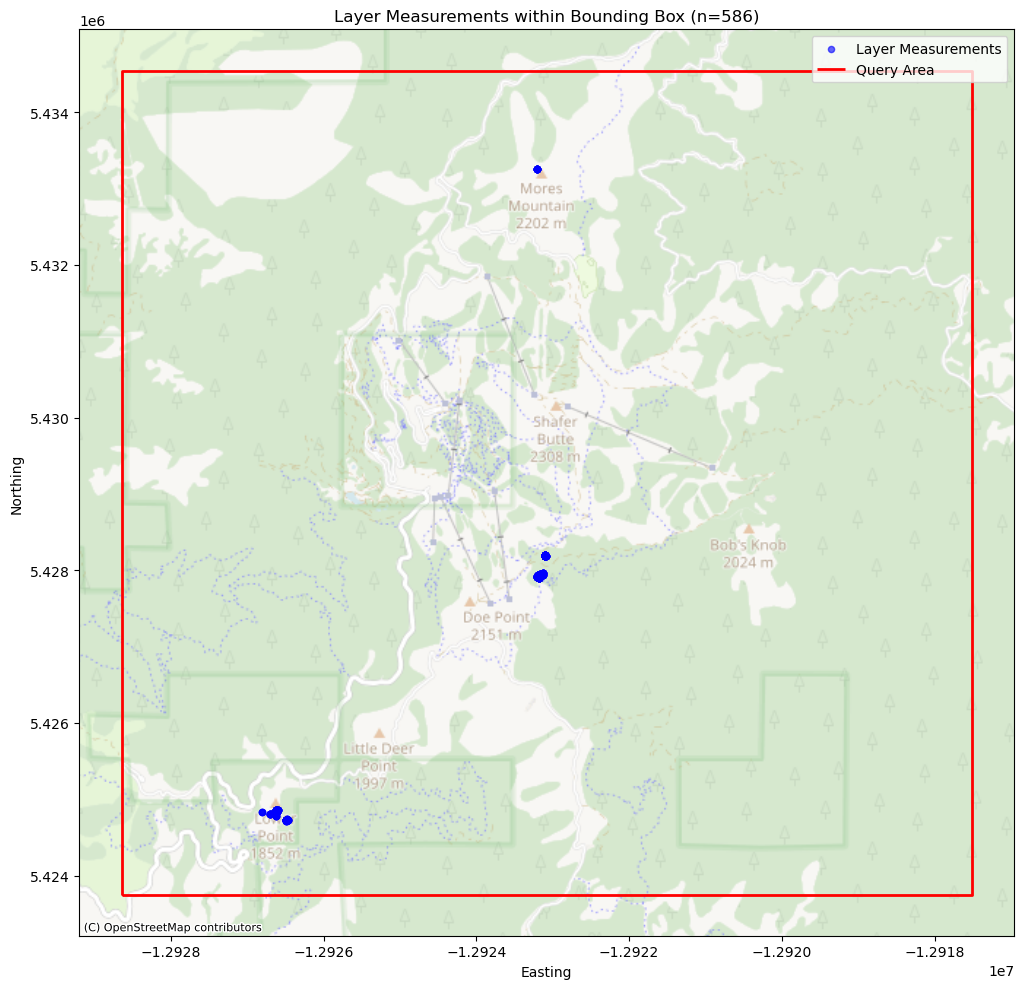

In [15]:
# Reproject to Web Mercator for basemap
df_web = df.to_crs(epsg=3857)
bbox_web = bbox_gdf.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the data points
df_web.plot(ax=ax, color='blue', markersize=20, alpha=0.6, label='Layer Measurements')

# Plot bounding box
bbox_web.boundary.plot(ax=ax, color='red', linewidth=2, label='Query Area')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)

ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.set_title(f'Layer Measurements within Bounding Box (n={len(df)})')
ax.legend()
plt.tight_layout()
plt.show()

Let's look at what the query returns for columns. Note that the 'value' column is the measured value associated with the variable type you requested in the `from_area` query above. Note that it also returns values as strings, so we'll need to convert to numeric below. 

In [16]:
df.columns

Index(['depth', 'bottom_depth', 'value', 'site_name', 'site_description',
       'slope_angle', 'aspect', 'air_temp', 'total_depth',
       'weather_description', 'precip', 'sky_cover', 'wind',
       'ground_condition', 'ground_roughness', 'ground_vegetation',
       'vegetation_height', 'tree_canopy', 'site_comments', 'date', 'geom',
       'type', 'units', 'type_derived', 'instrument_name', 'instrument_model',
       'instrument_specifications', 'geom_wkt', 'geometry'],
      dtype='object')

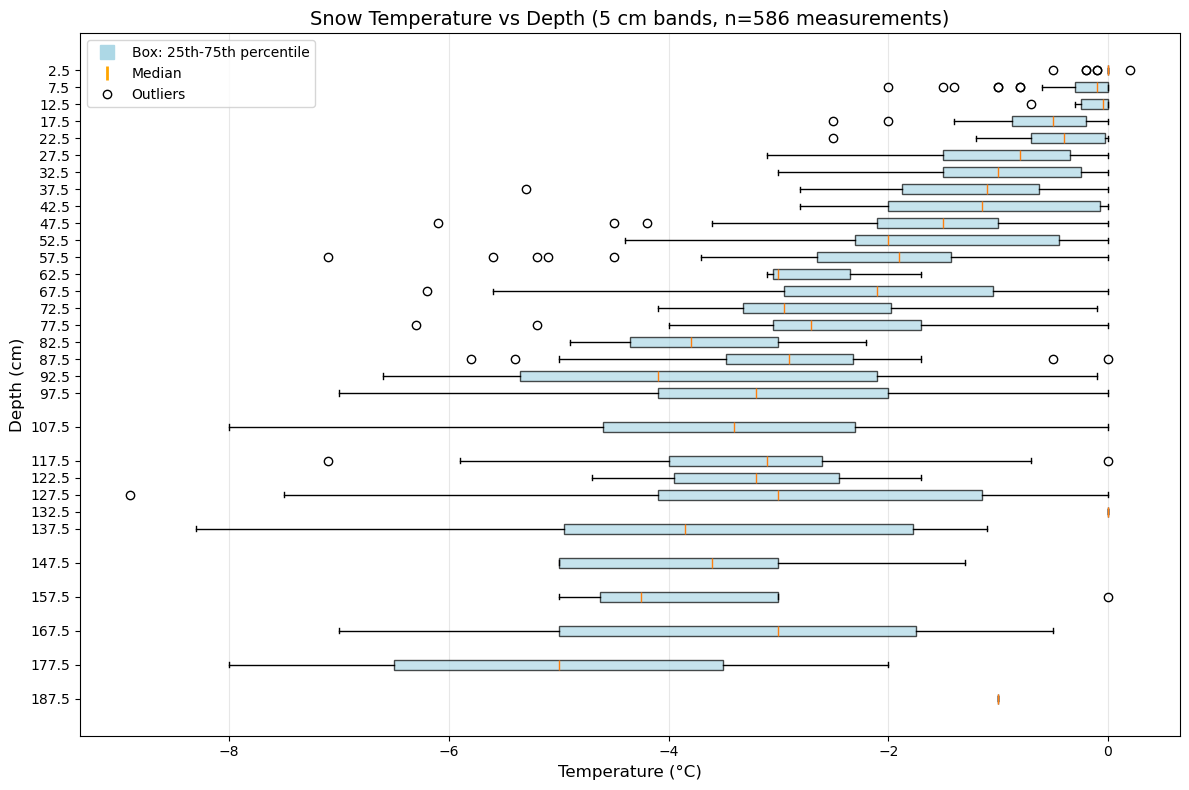


Depth range: 0.0 - 190.0 cm
Temperature range: -8.9 - 0.2 °C
Number of depth bands: 31


In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert value to numeric, coercing errors to NaN
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# Remove any NaN values that resulted from conversion
df = df.dropna(subset=['value', 'depth'])

# Create depth bands (bins) every 5 cm
bin_width = 5.0
min_depth = np.floor(df['depth'].min())
max_depth = np.ceil(df['depth'].max())
bins = np.arange(min_depth, max_depth + bin_width, bin_width)

# Assign each measurement to a depth band
df['depth_band'] = pd.cut(df['depth'], bins=bins, labels=bins[:-1] + bin_width/2, include_lowest=True)

# Get unique depth bands
depth_bands = sorted(df['depth_band'].dropna().unique())

# Prepare data for box plot - group by depth band
data_by_band = [df[df['depth_band'] == band]['value'].values for band in depth_bands]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Create box plot
bp = ax.boxplot(data_by_band, positions=depth_bands, vert=False, 
                patch_artist=True, widths=3.0)

# Customize box colors
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

# Invert y-axis so depth increases downward
ax.invert_yaxis()

ax.set_xlabel('Temperature (°C)', fontsize=12)
ax.set_ylabel('Depth (cm)', fontsize=12)
ax.set_title(f'Snow Temperature vs Depth (5 cm bands, n={len(df)} measurements)', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')

# Add legend explaining box plot elements
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='lightblue', marker='s', markersize=10, 
           label='Box: 25th-75th percentile', linestyle=''),
    Line2D([0], [0], color='orange', marker='|', markersize=10, 
           label='Median', linestyle='', markeredgewidth=2),
    Line2D([0], [0], color='black', marker='o', markersize=6, 
           label='Outliers', linestyle='', markerfacecolor='white')
]
ax.legend(handles=legend_elements, loc='best', fontsize=10)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nDepth range: {df['depth'].min():.1f} - {df['depth'].max():.1f} cm")
print(f"Temperature range: {df['value'].min():.1f} - {df['value'].max():.1f} °C")
print(f"Number of depth bands: {len(depth_bands)}")

## Point Data

Let's see what types of point data are available:

In [19]:
# Get all available types first
all_types = PointMeasurements.all_types
print(f"Available types: {all_types}")

Available types: ['two_way_travel', 'depth', 'swe', 'density']


Let's work with depth data on Grand Mesa.

In [20]:
# Create polygon from bounding box (minx, miny, maxx, maxy)
bbox_polygon = box(
    minx=-108.195487,
    miny=39.031819,
    maxx=-108.189329,
    maxy=39.036568
)

# Convert to WKT for query
bbox_wkt = bbox_polygon.wkt

# Create a GeoDataFrame from the bounding box polygon
bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox_polygon], crs='EPSG:4326')

# Reproject to Web Mercator for basemap
bbox_gdf_web = bbox_gdf.to_crs(epsg=3857)

In [21]:
print("Getting layer data within bounding box...")
df = PointMeasurements.from_area(
    shp=bbox_polygon,
    crs=4326,
    type='depth',
    limit=30000,
    verbose=False
)

print(f"Retrieved {len(df)} records.")

Getting layer data within bounding box...
Retrieved 30000 records.


In [22]:
df.head()

,id,value,datetime,elevation,geom,geometry
0,1264978,99.878703,2020-01-28T16:15:51+00:00,3040.731,0101000020e610000081a765bb370c5bc023015b096684...,POINT (-108.1909 39.03436)
1,1264979,101.096736,2020-01-28T16:15:51+00:00,3040.737,0101000020e610000066d39cbc370c5bc02285b1066684...,POINT (-108.1909 39.03436)
2,1264980,101.096736,2020-01-28T16:15:52+00:00,3040.744,0101000020e61000006163e0bd370c5bc004a208046684...,POINT (-108.1909 39.03436)
3,1264981,101.096736,2020-01-28T16:15:52+00:00,3040.749,0101000020e61000007f5524bf370c5bc0d26a4c016684...,POINT (-108.1909 39.03436)
4,1264982,101.096736,2020-01-28T16:15:52+00:00,3040.754,0101000020e610000063815bc0370c5bc0b4eea2fe6584...,POINT (-108.1909 39.03436)


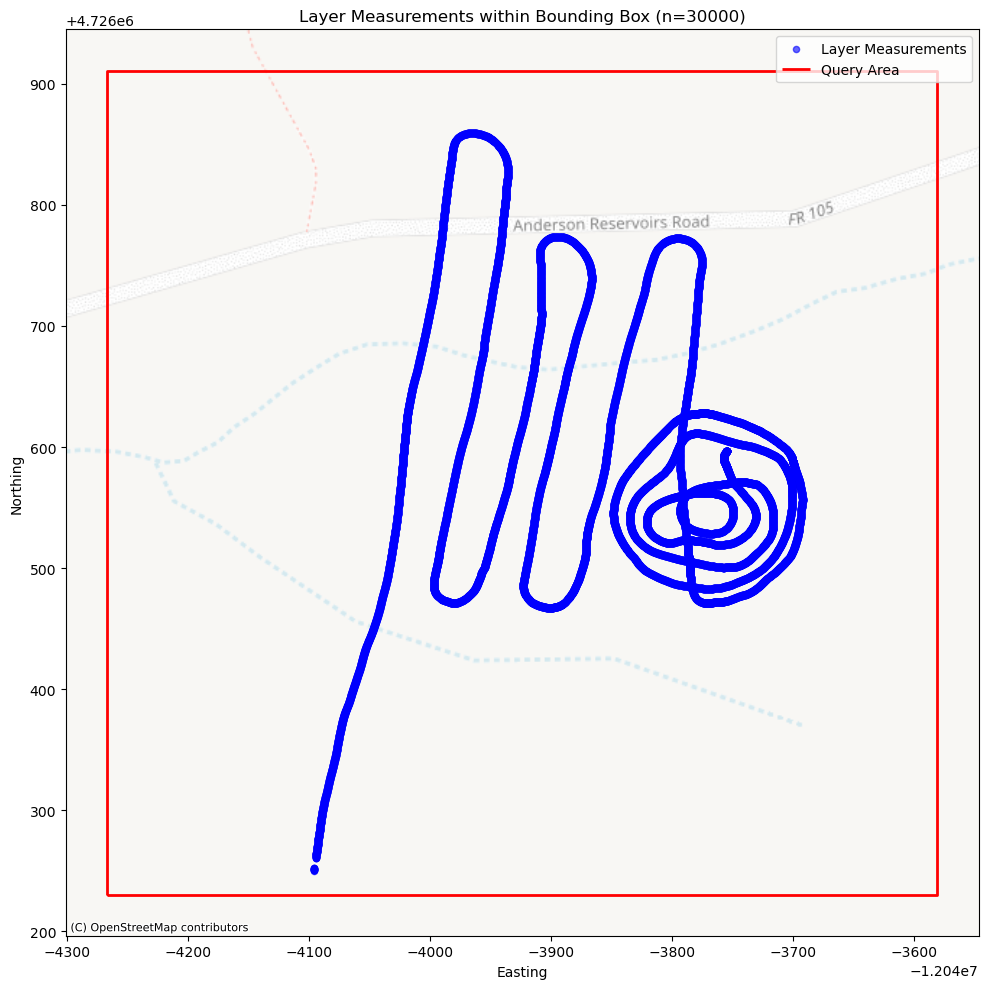

In [23]:
# Reproject to Web Mercator for basemap
df_web = df.to_crs(epsg=3857)
bbox_web = bbox_gdf.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the data points
df_web.plot(ax=ax, color='blue', markersize=20, alpha=0.6, label='Layer Measurements')

# Plot bounding box
bbox_web.boundary.plot(ax=ax, color='red', linewidth=2, label='Query Area')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)

ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.set_title(f'Layer Measurements within Bounding Box (n={len(df)})')
ax.legend()
plt.tight_layout()
plt.show()

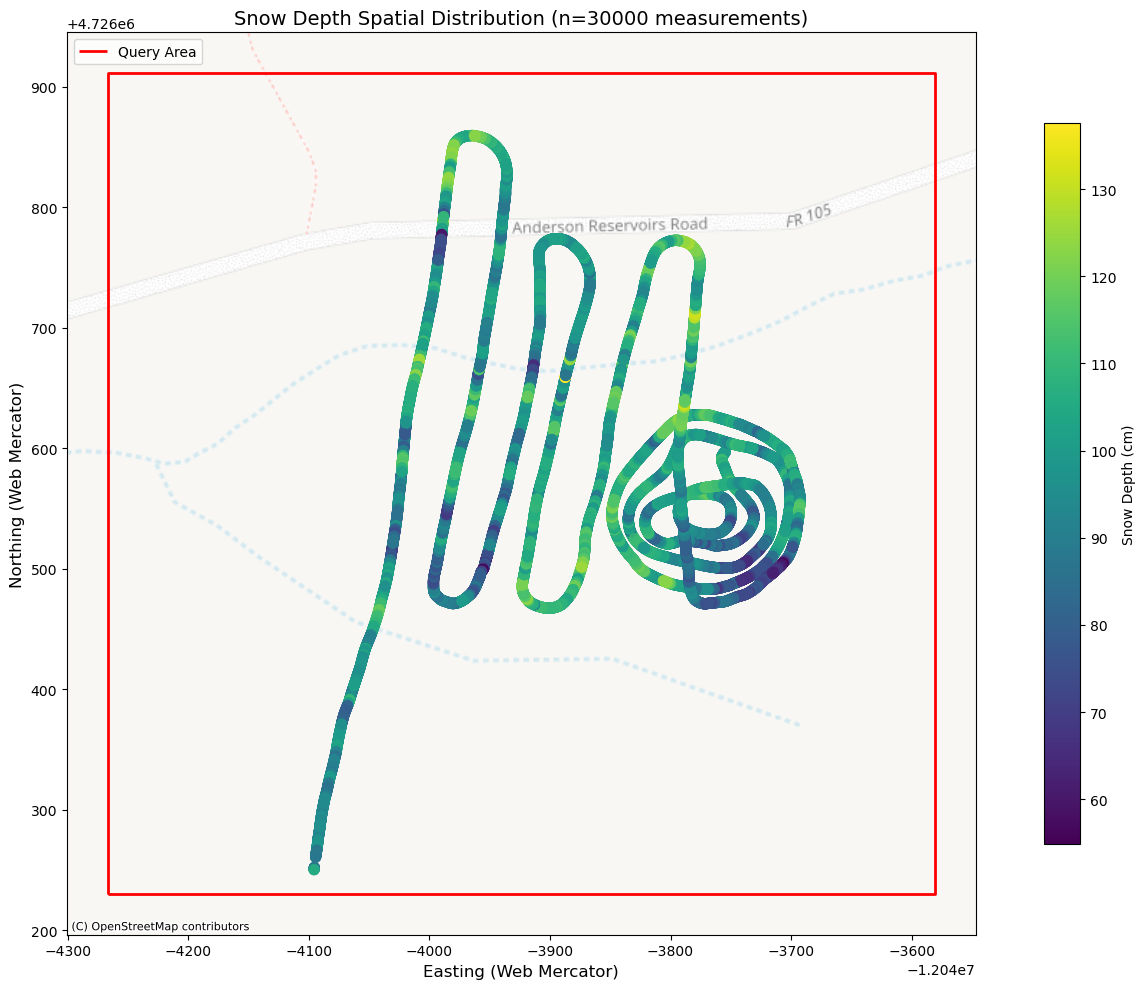


Snow Depth Statistics:
  Mean: 98.2 cm
  Median: 99.9 cm
  Min: 54.8 cm
  Max: 137.6 cm
  Std Dev: 12.6 cm


In [24]:
# Reproject to Web Mercator for basemap
df_web = df.to_crs(epsg=3857)
bbox_web = bbox_gdf.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(14, 10))

# Plot the data points colored by depth value
scatter = df_web.plot(
    ax=ax, 
    column='value',  # Color by snow depth
    cmap='viridis',  # Color scheme
    markersize=50, 
    alpha=0.7,
    legend=True,
    legend_kwds={
        'label': 'Snow Depth (cm)',
        'orientation': 'vertical',
        'shrink': 0.8
    }
)

# Plot bounding box
bbox_web.boundary.plot(ax=ax, color='red', linewidth=2, label='Query Area')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)

ax.set_xlabel('Easting (Web Mercator)', fontsize=12)
ax.set_ylabel('Northing (Web Mercator)', fontsize=12)
ax.set_title(f'Snow Depth Spatial Distribution (n={len(df)} measurements)', fontsize=14)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSnow Depth Statistics:")
print(f"  Mean: {df['value'].mean():.1f} cm")
print(f"  Median: {df['value'].median():.1f} cm")
print(f"  Min: {df['value'].min():.1f} cm")
print(f"  Max: {df['value'].max():.1f} cm")
print(f"  Std Dev: {df['value'].std():.1f} cm")

Initial example with `from_filter`.

In [25]:
df = PointMeasurements.from_filter(
    type='swe',
    limit=10000,
    verbose=False
)

In [119]:
df.head()

,id,value,datetime,elevation,geom,geometry
0,3897073,149.0,2023-03-09T00:00:00+00:00,265.42,0101000020e61000001436a533e47062c03fb4a535a149...,POINT (-147.52786 65.15046)
1,3897074,149.0,2023-03-09T00:00:00+00:00,265.43,0101000020e610000068298a37e47062c0ce0acc33a149...,POINT (-147.52786 65.15046)
2,3897075,149.0,2023-03-09T00:00:00+00:00,265.43,0101000020e6100000c8226f3be47062c0e37ef231a149...,POINT (-147.52786 65.15046)
3,3897076,147.0,2023-03-09T00:00:00+00:00,265.44,0101000020e6100000054b543fe47062c0b1ed1830a149...,POINT (-147.52786 65.15046)
4,3897077,147.0,2023-03-09T00:00:00+00:00,265.45,0101000020e6100000593e3943e47062c09e4b3f2ea149...,POINT (-147.52786 65.15046)
